# Gaussian Processes and Support Vector Machines

In [1]:
%pylab inline
plt.rcParams["figure.figsize"] = [20,10]

Populating the interactive namespace from numpy and matplotlib


In [2]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

## Part 1: Gaussian Processes

This noteboke makes use of Bishop sections 6.4.2 and 6.4.3. 

Book pdf link: [Bishop, Pattern recognition and Machine Learning](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf)

$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\ba}{\mathbf{a}}$

### Periodic Data

First, periodic data is generated with possible noise. The generated data and the true mean are displayed in the figure.

In [3]:
def true_mean_function(x):
    return np.sin(2*pi*(x+1))

def add_noise(y, sigma):
    return y + sigma*np.random.randn(len(y))

def generate_t(x, sigma):
    return add_noise(true_mean_function(x), sigma)


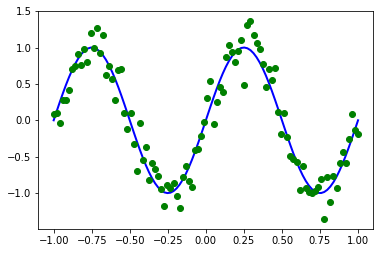

In [4]:
#Visualizing the data
sigma = 0.2
beta  = 1.0 / pow(sigma, 2)
N_test = 100

x_test = np.linspace(-1, 1, N_test) 
mu_test = np.zeros(N_test)
y_test = true_mean_function(x_test)
t_test = add_noise(y_test, sigma)

plt.plot( x_test, y_test, 'b-', lw=2)
plt.plot( x_test, t_test, 'go')
plt.show()

### Sampling from the Gaussian process prior
A Gaussian process regression using the kernel function in Bishop Eqn. 6.63 will be implemented.
This makes use of a kernel function. Kernels are crucial for high dimensional data, as the be equivalent to a basis function of high and even infinite dimension, without explicitly doing the computation for that basis function.

To start, the function `k_n_m(xn, xm, thetas)` that takes scalars $x_n$ and $x_m$, and a vector of $4$ thetas, and computes the kernel function Bishop Eqn. 6.63 is implemented.  NB: usually the kernel function will take $D$ by $1$ vectors, but since a univariate problem is used, this makes things easier.

Next, a function `computeK(x1, x2, thetas)` that computes the kernel matrix is implemented. Here, an inner loop with k_n_m is used. There are more efficient ways of computing the kernel function, making use of vectorization, but this method is sufficient fast for the simple problem at hand.

Consequently, mean functions at the x\_test locations for a set of theta values are sampled. This is done five times for each theta. These are displayed in the plots below. Additionally, the plots include the expected value of $\by$ with a dashed line and display the uncertainty due to $\mathbf{K}$ with the shaded area (the diagonal of $\mathbf{K}$ is the variance of the model uncertainty)

In [5]:
def k_n_m(xn, xm, thetas):
    k = thetas[0] * np.exp(-thetas[1]/2 * np.square(np.sqrt(np.square(xn - xm)))) + thetas[2] + thetas[3] * xn * xm  
    return k

In [6]:
def computeK(x1, x2, thetas):
    K = np.zeros((len(x1), len(x2)))
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            K[i, j] = k_n_m(x1[i], x2[j], thetas)   
    return K


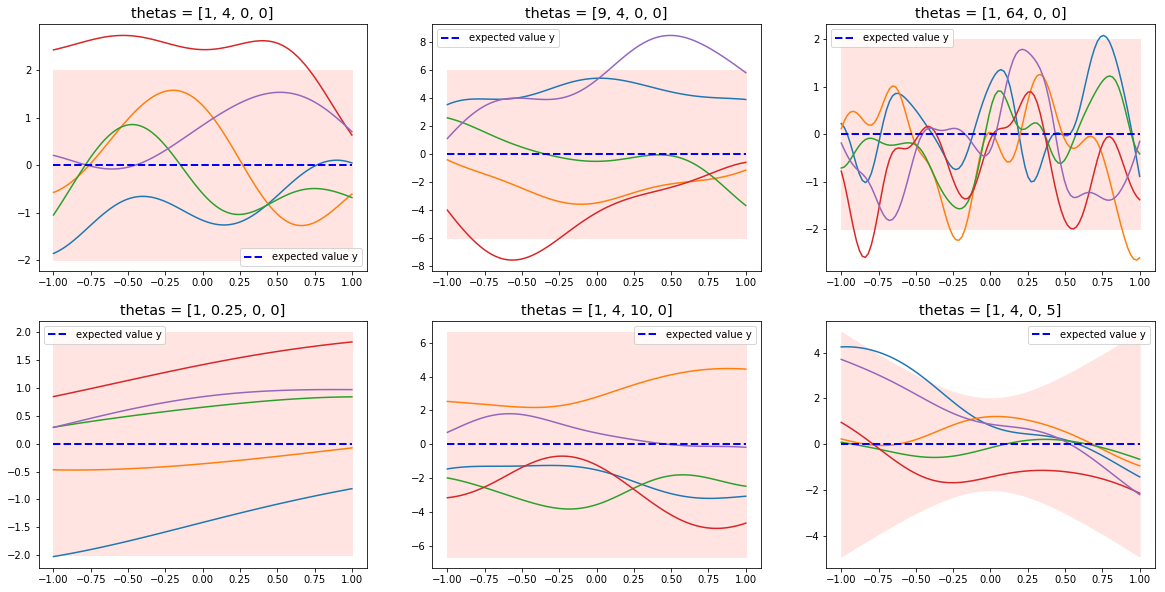

In [7]:
def thetas_plot(x, y, mu, thetas_list, num_samples=5):    
    plt.figure(figsize=(20, 10), facecolor='white')
    
    for i in range(len(thetas_list)):
        K = computeK(x, x, thetas_list[i])
        plt.subplot(2, 3, i+1)

        for j in range(num_samples):
            yi = np.random.multivariate_normal(mu, K)
            plt.plot(x, yi)
        
        plt.title('thetas = '+ str(thetas_list[i]), fontsize='x-large')   
        plt.plot(x, mu, 'b--', lw=2, label='expected value y')
        # plt.plot(x, y,  'k--', lw=2, label='')
        sigma = np.sqrt(np.diag(K))
        plt.fill_between(x, mu+2*sigma, mu-2*sigma, color='mistyrose')
        plt.legend()

    plt.show()

thetas_list = [[1, 4, 0, 0], [9, 4, 0, 0], [1, 64, 0, 0], [1, 0.25, 0, 0], [1, 4, 10, 0], [1, 4, 0, 5]]  
thetas_plot(x_test, y_test, mu_test, thetas_list)


### Predictive distribution

Once data is obtained, we are interested in the predictive distribution (note: the prior is the predictive distribution when there is no data).  The joint distribution for $N+1$ targets, given by Eqn 6.64, is considered.  Its covariance matrix is composed of block components $\mathbf{C}_N$, $\mathbf{k}$, and $c$.  The covariance matrix $\mathbf{C}_N$ for $\bt_N$ is $\mathbf{C}_N = \mathbf{K}_N + \beta^{-1}\mathbf{I}_N$.  We have just made explicit the size $N$ of the matrix; $N$ is the number of training points.  The kernel vector $\mathbf{k}$ is a $N$ by $1$ vector of kernel function evaluations between the training input data and the test input vector.  The scalar $c$ is a kernel evaluation at the test input.

A function `gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C=None)` is implemented, that computes  Eqns 6.66 and 6.67, except allows for an arbitrary number of test points (not just one) and now the kernel matrix is for training data. This gives:

- $\mathbf{K}$: $K_{n,m} = k(x_{\text{train},n}, x_{\text{train},m})$; $\mathbf{K}$ is a $N_\text{train}\times N_\text{train}$ matrix
- $\mathbf{C}$: $\mathbf{C} = \mathbf{K} + \beta^{-1}\mathbf{I}$; $\mathbf{C}$ is a $N_\text{train}\times N_\text{train}$ matrix
- $\mathbf{k}$: $k_{n,m} = k(x_{\text{train},n}, x_{\text{test},m})$; $\mathbf{k}$ is a $N_\text{train}\times N_\text{test}$ matrix
- $\mathbf{c}$: $c_{n,m} = k(x_{\text{test},n}, x_{\text{test},m}) + \beta^{-1}$ if $n=m$ and $0$ otherwise; $\mathbf{c}$ is a $N_\text{test}\times N_\text{test}$ matrix

Now Eqns 6.66 and 6.67  become
- $\mu = \mathbf{k}^T\mathbf{C}^{-1}\mathbf{t}$; $\mu$ is a vector of length $N_\text{test}$
- $\Sigma = \mathbf{c} - \mathbf{k}^T\mathbf{C}^{-1}\mathbf{k}$; $\Sigma$ is a $N_\text{test}\times N_\text{test}$ matrix

Last, the standard deviation for every data point in the test vector $x_{\text{test}}$ is given by

- $\sigma = \sqrt{\text{diag}(\Sigma)}$,

where $\sigma$ is a vector of length $N_\text{test}$.


By having C as an optional parameter in the function we can avoid computing it more than once (for this problem it is unimportant, but for real problems this is an issue).  The function computes $\mathbf{C}$, $\mathbf{k}$, and return the mean, standard deviation and $\mathbf{C}$.

Next, the log-likelihood of the training data needs to be computed, in order to learn the hyperparameters. Implicitly, this is conditioned on the value setting for $\mathbf{\theta}$. The function `gp_log_likelihood(x_train, t_train, theta, C=None, invC=None, beta=None)`, where C and invC can be stored and reused, is implemented. It returns the log-likelihood, `C` and `invC`.

#### Plots

Finally, two sets of plots are generated. First, the 6 plots shown above are repeated, but this time conditioned on the training points. The periodic data generator is used to create 2 training points where x is sampled uniformly between $-1$ and $1$.

This is than repeated, but this time conditioned a new set of 10 training points.




In [8]:
def gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C=None):    
    
    if C is None:
        K = computeK(x_train, x_train, theta)
        C = K + 1/beta * np.identity(x_train.shape[0])

    invC = np.linalg.inv(C)

    k = computeK(x_train, x_test, theta)

    mean_test = k.T @ invC @ t_train
    sigma = computeSigma(x_test, k, invC, theta)
    std_test = np.sqrt(np.diag(sigma))
    
    return mean_test, std_test, C

def computeSigma(x, k, invC, theta):
    c = np.diag(np.diag(computeK(x, x, theta))+ 1/beta)
    sigma = c - k.T @ invC @ k
    return sigma

In [9]:
def gp_log_likelihood(x_train, t_train, theta, beta, C=None, invC=None):    
    if C is None:
        K = computeK(x_train, x_train, theta)
        C = K + 1/beta * np.identity(x_train.shape[0])
    if invC is None:
        invC = np.linalg.inv(C)            
    lp = -0.5 * np.log(np.linalg.det(C)) - 0.5 * t_train.T @ invC @ t_train - 0.5 * len(x_train) * np.log(2*np.pi)    
    return lp, C, invC

In [10]:
def gp_plot( x_test, y_test, mean_test, std_test, x_train, t_train, theta, beta ):
    # x_test: 
    # y_test:    the true function at x_test
    # mean_test: predictive mean at x_test
    # var_test:  predictive covariance at x_test 
    # t_train:   the training values
    # theta:     the kernel parameters
    # beta:      the precision (known)
    
    # the reason for the manipulation is to allow plots separating model and data stddevs.      # includes all uncertainty, model and target noise 
    std_model = np.sqrt(std_test**2 - 1.0/beta)  # remove data noise to get model uncertainty in stddev
    std_combo = std_model + np.sqrt(1.0/beta)    # add stddev (note: not the same as full)
    
    plt.plot(x_test, y_test, 'b', lw=3)
    plt.plot(x_test, mean_test, 'k--', lw=2)
    plt.fill_between(x_test, mean_test+2*std_combo,mean_test-2*std_combo, color='k', alpha=0.25)
    plt.fill_between(x_test, mean_test+2*std_model,mean_test-2*std_model, color='r', alpha=0.25)
    plt.plot(x_train, t_train, 'ro', ms=10)
    

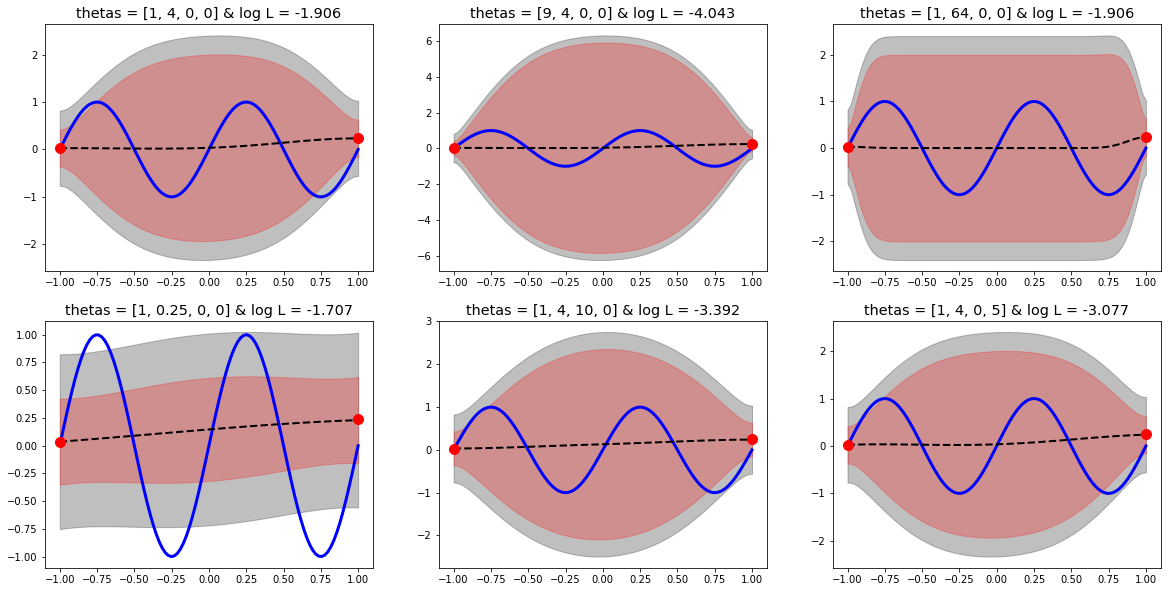

In [11]:
#Given
# x_test:    the given x-test, 
# mean_test: predictive mean at x_test, (truemeanfunction(x))
# theta:     the kernel parameters
# beta:      the precision (known)

#To compute
# y_test:    the computed y-test, from x-train and t_train
# y-test: Multivariate normal, with computed mean and std dev
# var_test:  predictive covariance at x_test 
# t_train:   the training values

def plot2(train_N):
    train_sigma = 0.2
    beta  = 1.0 / pow(train_sigma, 2)
    thetas_list = [[1, 4, 0, 0], [9, 4, 0, 0], [1, 64, 0, 0], [1, 0.25, 0, 0], [1, 4, 10, 0], [1, 4, 0, 5]]

    train_x = np.linspace(-1, 1, train_N) 
    train_y = true_mean_function(train_x)
    train_t = add_noise(train_y, train_sigma)

    test_N = 100
    test_x = np.linspace(-1, 1, test_N)
    test_y = true_mean_function(test_x)

    test_x = x_test
    test_y = y_test

    plt.figure(figsize=(20, 10), facecolor='white')

    for i in range(len(thetas_list)):
        
        theta = thetas_list[i]
        plt.subplot(2, 3, i + 1)
                    
        test_mean, test_std, C = gp_predictive_distribution(train_x, train_t, test_x, theta, beta, C=None)     

        lp, C, invC = gp_log_likelihood(train_x, train_t, theta, beta, C=C, invC=None)

        lp = round(lp, 3)

        plt.title('thetas = '+ str(thetas_list[i]) + ' & log L = ' + str(lp),  fontsize='x-large')

        gp_plot(test_x, test_y, test_mean, test_std, train_x, train_t, theta, beta)

    plt.show()
    
plot2(2)


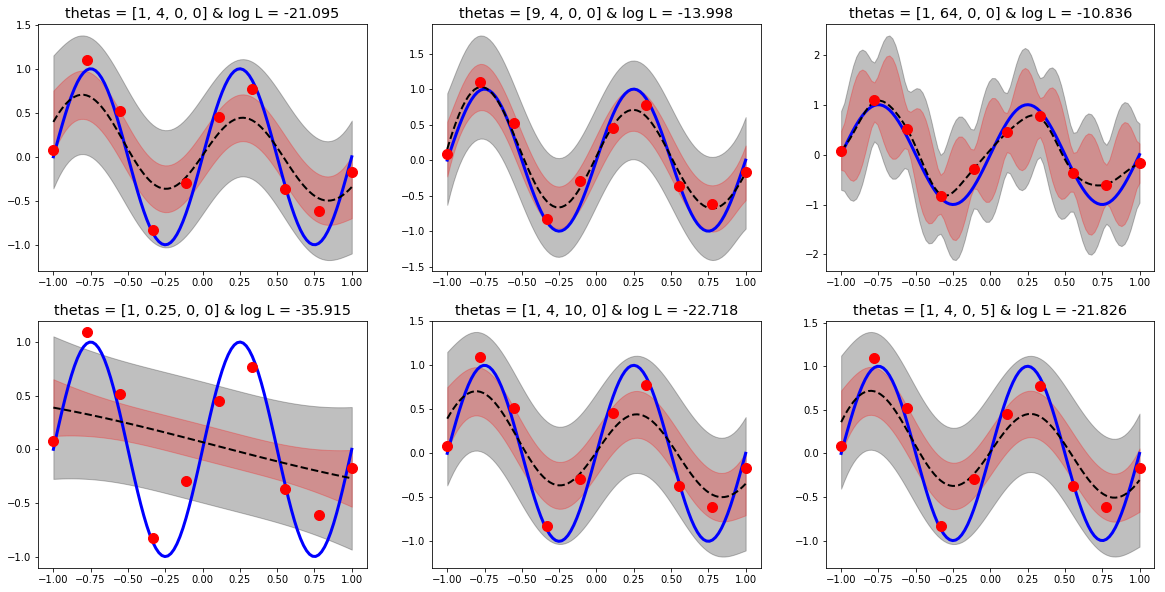

In [12]:
plot2(10)

## Part 2: Support Vector Machines

As seen in Part 1: Gaussian Processes, one of the significant limitations of many such algorithms is that the kernel function $k(\bx_n , \bx_m)$ must be evaluated for all possible pairs $\bx_n$ and $\bx_m$ of training points, which can be computationally infeasible during training and can lead to excessive computation times when making predictions for new data points.
In Part 2: Support Vector Machines, looks at kernel-based algorithms that have sparse solutions, so that predictions for new inputs depend only on the kernel function evaluated at a subset of the training data points.

### Generating a linearly separable dataset

First, a linearly separable dataset is created. The dataset consists of two i.i.d. subsets $X_1$ and $X_2$, each of the subsets is sampled from a multivariate Gaussian distribution,

\begin{align}
X_1 \sim &\mathcal{N}(\mu_1, \Sigma_1)\\
&\text{ and }\\
X_2 \sim &\mathcal{N}(\mu_2, \Sigma_2).
\end{align}

In the following, $X_1$ will have $N_1=20$ samples and a mean $\mu_1=(1,1)$. $X_2$ will have $N_2=30$ samples and a mean $\mu_2=(3,3)$.

The data is shown in the figure below.

Consequently, the two dataasets X_1, X_2 are combined an a vector `t` containing the labels is generated. This is done in function `create_X_and_t(X1, X2)`

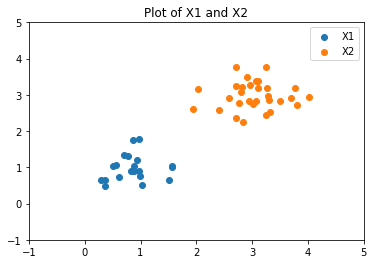

In [13]:
cov = 0.2
N1 = 20
N2 = 30
mu1 = [1,1]
mu2 = [3,3]
cov1 = [[cov, 0], [0,cov]]
cov2 = [[cov, 0], [0,cov]]

X1 = np.random.multivariate_normal(mu1, cov1, N1)
X2 = np.random.multivariate_normal(mu2, cov2, N2)

fig, ax = plt.subplots()
fig.set_facecolor('white')
ax.scatter(X1[:,0], X1[:,1], label='X1')
ax.scatter(X2[:,0], X2[:,1], label='X2')
ax.set_xlim((-1, 5))
ax.set_ylim((-1,5))
ax.legend()
ax.set_title('Plot of X1 and X2')


In [14]:
def create_X_and_t(X1, X2):
    N1 = X1.shape[0]
    N2 = X2.shape[0]
    t1 = np.array([1] * N1).reshape(N1, )
    t2 = np.array([-1] * N2).reshape(N2, )

    X = np.concatenate((X1, X2))
    t = np.concatenate((t1, t2))

    return X, t 

### Finding the support vectors

Now, SVM is used to obtain the decision boundary for which the margin is maximized. The following optimization problem has to be solved to do so:

\begin{align}
\arg \min_{\bw, b} \frac{1}{2} \lVert \bw \rVert^2,
\end{align}

subject to the constraints

\begin{align}
t_n(\bw^T \phi(\bx_n) + b) \geq 1, n = 1,...,N.
\end{align}

In order to solve this constrained optimization problem, the Lagrange multipliers $a_n \geq 0$ are introduced. The dual
representation of the maximum margin problem is obtained, in which we maximize

\begin{align}
\sum_{n=1}^N a_n - \frac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m t_n t_m k(\bx_n, \bx_m),
\end{align}

with respect to a subject to the constraints

\begin{align}
a_n &\geq 0, n=1,...,N,\\
\sum_{n=1}^N a_n t_n &= 0.
\end{align}

This takes the form of a quadratic programming problem in which a quadratic function of $\mathbf{a}$ is optimized, subject to a set of inequality constraints.

In the example a linear kernel $k(\bx, \bx') = \bx^T\bx'$ is used. A function `computeK(X)` that computes the kernel matrix $K$ for the 2D dataset $X$ is implemented.

Next, the dual representation is rewritten so that computationally efficient vector-matrix multiplication can be used. The objective becomes

\begin{align}
\min_{\ba} \frac{1}{2} \ba^T K' \ba - 1^T\ba,
\end{align}

subject to the constraints

\begin{align}
a_n &\geq 0, n=1,...,N,\\
\bt^T\ba &= 0.
\end{align}

Where
\begin{align}
K'_{nm} = t_n t_m k(\bx_n, \bx_m),
\end{align}
and in the special case of a linear kernel function,
\begin{align}
K'_{nm} = t_n t_m k(\bx_n, \bx_m) = k(t_n \bx_n, t_m \bx_m).
\end{align}

This quadratic programming problem is solved with the python module cvxopt. This is done in the function `compute_multipliers(X, t)` that solves the quadratic programming problem using the cvxopt module and returns the lagrangian multiplier for every sample in the dataset. 

With the obtained lagrangian multipliers, the support vectors can be found (the points for which the multiplier value is approximately equal to zero). The previous plot is repeated, but now with the support vectors indicated.


In [15]:
def computeK(X):    
    K = X @ X.T    
    return K

In [16]:
from cvxopt import matrix, solvers
import cvxopt

def compute_multipliers(X, t):

    N = X.shape[0]
    q = matrix(np.ones(N).reshape(N, 1) * -1)
    A = t.T.reshape(1, N).astype(float)
    A  = matrix(A)
    b = matrix(np.zeros(1))
    h = matrix(np.zeros(N).reshape(N, 1))
    G = matrix(-1 * np.identity(N))

    Xn = X * t.reshape(N,1)
    K = computeK(Xn)
    K = K.astype(float)

    P = cvxopt.matrix(K)
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    a = np.array(sol['x'])
    
    return a

     pcost       dcost       gap    pres   dres
 0: -3.7561e+00 -6.8015e+00  1e+02  1e+01  2e+00
 1: -3.1377e+00 -2.2311e+00  1e+01  9e-01  2e-01
 2: -7.2423e-01 -1.4612e+00  7e-01  6e-16  6e-15
 3: -1.0975e+00 -1.2276e+00  1e-01  2e-16  2e-15
 4: -1.2074e+00 -1.2142e+00  7e-03  1e-16  3e-15
 5: -1.2133e+00 -1.2135e+00  2e-04  5e-16  3e-15
 6: -1.2135e+00 -1.2135e+00  3e-06  4e-16  2e-15
 7: -1.2135e+00 -1.2135e+00  3e-08  3e-16  3e-15
Optimal solution found.


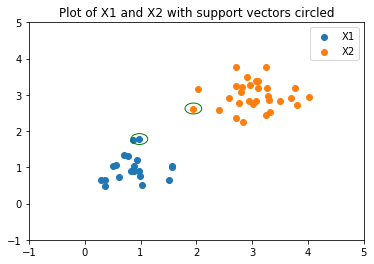

In [17]:
X, t = create_X_and_t(X1, X2)
a = compute_multipliers(X, t)

threshold = 1e-5
a_list = a.tolist()
SV = (a > threshold)

SV = [i[0] for i in a_list if i[0] > threshold]
SV_index = [(a_list.index(i)) for i in a_list if i[0] > threshold]

fig, ax = plt.subplots()

ax.scatter(X1[:,0], X1[:,1], label='X1')
ax.scatter(X2[:,0], X2[:,1], label='X2')
ax.set_xlim((-1, 5))
ax.set_ylim((-1,5))

ax.set_title('Plot of X1 and X2 with support vectors circled')

for i in SV_index:
    circle = plt.Circle((X[i,0], X[i,1]), 0.15, fill=False, color='green', label='SV')
    ax.add_artist(circle)

ax.legend()

### Plot the decision boundary
The decision boundary is fully specified by a (usually very small) subset of training samples, the support vectors. The slope and intercept of the decision boundary is calcualted, making use of

\begin{align}
\bw &= \sum_{n=1}^N a_n t_n \mathbf{\phi}(\bx_n)\\
b &= \frac{1}{N_S}\sum_{n \in S} (t_n - \sum_{m \in S} a_m t_m k(\bx_n, \bx_m)),
\end{align}

A final plot is generated, that contains the two subsets, support vectors and decision boundary.

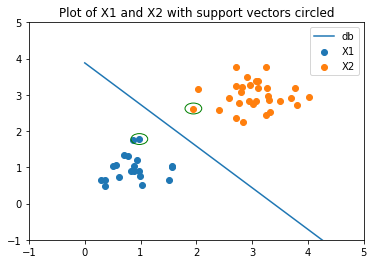

In [18]:
K = computeK(X)
N = X.shape[0]
a_t = a.reshape(N,1) * t.reshape(N,1)
w = a_t.T @ X
b_temp = []

for i_n in SV_index:
    temp_m = [a[i_m][0] * t[i_m] * K[i_n, i_m] for i_m in SV_index]
    temp = t[i_n] - sum(temp_m)
    b_temp.append(temp)

b = mean(b_temp)
x = np.linspace(0, 5, 100)
y = - w[0][0] / w[0][1] * x - b / w[0][1]
fig, ax = plt.subplots()

ax.scatter(X1[:,0], X1[:,1], label='X1')
ax.scatter(X2[:,0], X2[:,1], label='X2')
for i in SV_index:
    circle = plt.Circle((X[i,0], X[i,1]), 0.15, fill=False, color='green', label='SV')
    ax.add_artist(circle)

ax.plot(x, y, label='db')
ax.set_xlim((-1, 5))
ax.set_ylim((-1,5))
ax.legend()
ax.set_title('Plot of X1 and X2 with support vectors circled')

